## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

import cupy as cp
from tomo_encoders import Patches
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d, rec_patch, rec_pts, rec_pts_xy, rec_mask
# from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu

In [2]:
r_fac = 0.2
ht = 32
wd = 2176
th = 1500
n_sel = int(ht*wd*wd*r_fac/(32**3))

In [3]:
# arguments to recon_chunk2: data, theta, center, p3d
data = np.random.normal(0,1,(th, ht, wd))
theta = np.linspace(0, np.pi, th, dtype = np.float32)
center = wd/2
p_sel = Patches((ht,wd,wd), initialize_by = 'regular-grid', patch_size = (32,32,32), n_points = n_sel)
print(f'r = N(P)/N(V): {len(p_sel)*32**3/(ht*wd*wd):.2f}')

r = N(P)/N(V): 0.20


In [4]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    data = cp.array(data, dtype = np.float32)
    theta = cp.array(theta, dtype = np.float32)
    center = cp.float32(center)
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for copying data to gpu: {t_meas:.2f} ms")

overhead for copying data to gpu: 284.42 ms


In [5]:
times = []
for i in range(5):
    obj_patch, t_ = rec_patch(data, theta, center, 0, wd, 0, wd, 0, ht, TIMEIT=True)
    print(f"time {t_:.2f} ms")
    times.append(t_)
print(f"time = {np.median(times):.2f} ms")    

time 1332.86 ms
time 1310.75 ms
time 1315.19 ms
time 1321.46 ms
time 1320.56 ms
time = 1320.56 ms


## rec_mask  
output to obj_mask  

In [6]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    vol = cp.zeros((ht,wd,wd), dtype='float32', order = 'C')
    
    for idx in range(len(p_sel)):
        
        s = (slice(p_sel.points[idx,0], p_sel.points[idx,0] + 32), \
             slice(p_sel.points[idx,1], p_sel.points[idx,1] + 32), \
             slice(p_sel.points[idx,2], p_sel.points[idx,2] + 32))
        
        vol[s] = cp.ones((32, 32, 32), dtype = 'float32')
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for making points array: {t_meas:.2f} ms")

overhead for making points array: 26.28 ms


In [7]:
times = []
for i in range(5):
    obj_mask = vol.copy()
    t_ = rec_mask(obj_mask, data, theta, center)
    times.append(t_)
print(f"time = {np.median(times):.2f} ms")        

TIME rec_patch: 276.41 ms
TIME rec_patch: 277.44 ms
TIME rec_patch: 278.01 ms
TIME rec_patch: 281.96 ms
TIME rec_patch: 278.02 ms
time = 278.01 ms


In [8]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    sub_vols = p_sel.extract(obj_mask, (32,32,32))
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for extracting sub_vols: {t_meas:.2f} ms")    

overhead for extracting sub_vols: 11.08 ms


In [9]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
sub_vols = sub_vols.get()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for copying sub_vols to cpu: {t_meas:.2f} ms")    

overhead for copying sub_vols to cpu: 30.97 ms


Does the reconstruction of points reconcile with the full volume? True


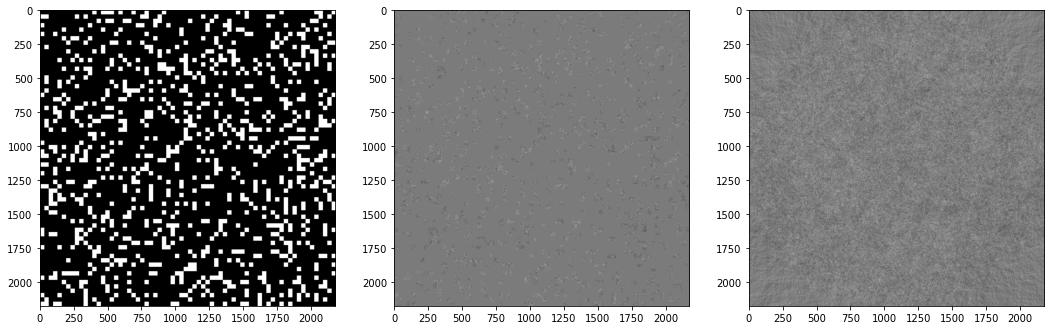

In [10]:
vox_coords = np.where(vol==1)
idp = ht//2
print(f'Does the reconstruction of points reconcile with the full volume? {~np.any(obj_patch[vox_coords]-obj_mask[vox_coords])}')
fig, ax = plt.subplots(1,3, figsize = (18,6))
ax[0].imshow(vol[idp].get(), cmap = 'gray')
ax[1].imshow(obj_mask.get()[idp], cmap = 'gray')
ax[2].imshow(obj_patch.get()[idp], cmap = 'gray')